This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, we try to generate random images from two classes,
where each class has a different image norm.
The question is: how robust are standard CNN models trained on this dataset?

V2 of this notebook uses data generators, so we can train on much larger datasets.
The drawback is that we don't have a fixed train set anymore.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data utils

[0 1 0 0 0 1 1 1 0 1]


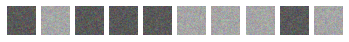

In [2]:
def generate_image_data(image_shape, m1, s1, m2, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(loc=m1, scale=s1, size=(num_samples // 2,) + image_shape),
        np.random.normal(loc=m2, scale=s2, size=(num_samples // 2,) + image_shape)
    ]).clip(0, 1)
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x)
        plt.axis("off")

x_tmp, y_tmp = generate_image_data(
    image_shape=(224, 224, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    num_samples=10
)

print(y_tmp)
plot_images(x_tmp)

In [3]:
class RandomImageGenerator(keras.utils.Sequence):
    """
    Follows guide from
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    
    TODO: Figure out how to code this to sample from fixed train set.
          A good candidate solution is JAX PRNG keys.
    """
    
    def __init__(
        self,
        image_shape,
        m1, s1,
        m2, s2,
        batch_size,
        num_batches,
    ):
        self.image_shape = image_shape
        self.m1 = m1
        self.s1 = s1
        self.m2 = m2
        self.s2 = s2
        self.batch_size = batch_size
        self.num_batches = num_batches

    def __len__(self):
        return self.num_batches

    def __getitem__(self, index):
        "Returns one batch of data."
        return generate_image_data(
            image_shape=self.image_shape,
            m1=self.m1, s1=self.s1,
            m2=self.m2, s2=self.s2,
            num_samples=self.batch_size,
        )

### Experiment setup

In [4]:
def run_experiment(
    image_shape,
    m1, s1,
    m2, s2,
    get_model,
    from_logits,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size,
    train_iters_per_epoch,
    attack_batch_size=64,
    num_test=512,
    workers=6,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    train_generator = RandomImageGenerator(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        batch_size=train_batch_size,
        num_batches=train_iters_per_epoch,
    )
    
    x_test, y_test = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_test,
    )

    model = get_model(x_test[0].shape)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        train_generator,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        validation_batch_size=attack_batch_size,
        verbose=1,
        workers=workers,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        clip_values=[x_test.min(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat test  acc :", nat_test_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        test_data=(x_test, y_test),
        x_test_adv=x_test_adv,
    )

### Run experiments

In [5]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_batch_size=32,
    train_iters_per_epoch=int(1e4 / 32),
    train_epochs=5,
    attack_norm=2,
    attack_eps=4,
    attack_eps_step=0.5,
    attack_iters=20,
)

Epoch 1/5
312/312 [==============================] - 40s 73ms/step - loss: 0.0206 - accuracy: 0.9886 - val_loss: 2.6185 - val_accuracy: 0.5000
Epoch 2/5
312/312 [==============================] - 18s 57ms/step - loss: 1.2595e-06 - accuracy: 1.0000 - val_loss: 2.1599e-06 - val_accuracy: 1.0000
Epoch 3/5
312/312 [==============================] - 18s 58ms/step - loss: 7.5532e-07 - accuracy: 1.0000 - val_loss: 7.7323e-07 - val_accuracy: 1.0000
Epoch 4/5
312/312 [==============================] - 18s 57ms/step - loss: 4.8320e-07 - accuracy: 1.0000 - val_loss: 5.5251e-07 - val_accuracy: 1.0000
Epoch 5/5
312/312 [==============================] - 18s 58ms/step - loss: 3.0865e-07 - accuracy: 1.0000 - val_loss: 4.2515e-07 - val_accuracy: 1.0000


PGD - Batches: 0it [00:00, ?it/s]

Nat test  acc : 1.0
Adv test  acc : 0.19921875
Wall time: 2min 19s


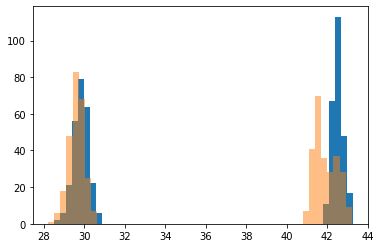

In [6]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

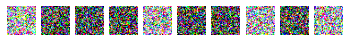

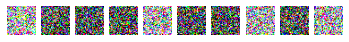

In [7]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])

---

In [11]:
%%time
res = run_experiment(
    image_shape=(224, 224, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_batch_size=32,
    train_iters_per_epoch=int(1e4 / 32),
    train_epochs=4,
    attack_norm=2,
    attack_eps=4 * 8,
    attack_eps_step=0.5,
    attack_iters=20 * 8,
    attack_batch_size=32,
    num_test=256,
)

Epoch 1/4
312/312 [==============================] - 63s 173ms/step - loss: 0.0143 - accuracy: 0.9899 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 2/4
312/312 [==============================] - 61s 193ms/step - loss: 2.8907e-07 - accuracy: 1.0000 - val_loss: 8.1025e-08 - val_accuracy: 1.0000
Epoch 3/4
312/312 [==============================] - 53s 166ms/step - loss: 1.5333e-07 - accuracy: 1.0000 - val_loss: 7.6368e-08 - val_accuracy: 1.0000
Epoch 4/4
312/312 [==============================] - 59s 188ms/step - loss: 1.0120e-07 - accuracy: 1.0000 - val_loss: 6.2864e-08 - val_accuracy: 1.0000


PGD - Batches: 0it [00:00, ?it/s]

Nat test  acc : 1.0
Adv test  acc : 0.5
Wall time: 8min 41s


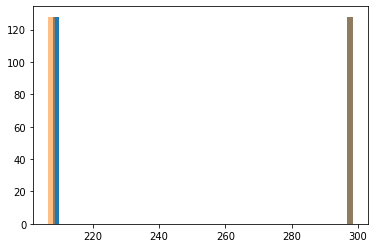

In [12]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

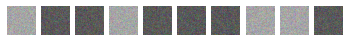

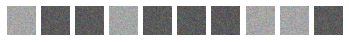

In [13]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])